# Lecture : Recommendation on Graphs

## Lab 02 : Collaborative recommendation -- Exercise

### Xavier Bresson, Nian Liu  


In [19]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/05_Recommendation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [20]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from IPython.display import display, clear_output
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import shrink
import scipy.sparse.linalg
import warnings; warnings.filterwarnings("ignore")


# Synthetic dataset 

In [21]:
# Load graphs of rows/users and columns/movies
mat = scipy.io.loadmat('datasets/synthetic_netflix.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining) / (n*m)
print('perc_obs_training=',perc_obs_training)


n,m= 150 200
perc_obs_training= 0.03


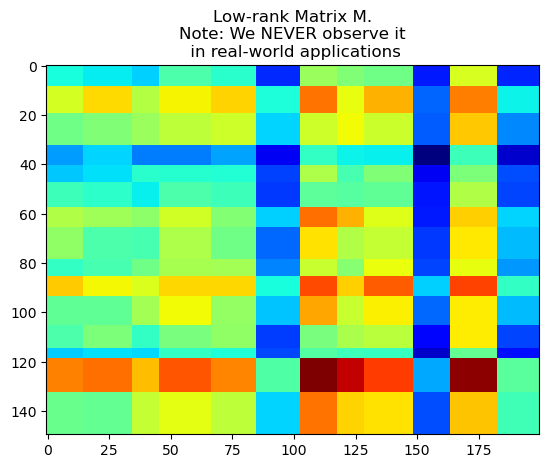

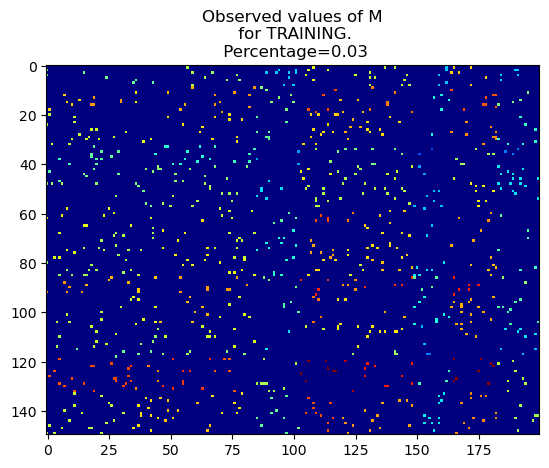

In [22]:
# Viusalize the rating matrix
plt.figure(1)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Low-rank Matrix M.\nNote: We NEVER observe it\n in real-world applications')
plt.show()

plt.figure(2)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M\n for TRAINING.\n Percentage=' + str(perc_obs_training))
plt.show()


### Question 1: Implement collaborative filtering using low-rank optimization with nuclear norm

Refer to Slide 30 of Lecture 5.

**Main Steps:**
1. Compute the SVD of the matrix $Y^k + \sigma^k X^k = U \Sigma V^\top$.
2. Update the dual variable $Y^{k+1}$.
3. Update the primal variable $X^{k+1}$.
4. For rows or columns without observations, fill in with the median value of the computed matrix $X$.

Hint: You may use the function `numpy.linalg.svd()` for SVD computation and the `shrink()` function for nuclear norm minimization.


Reconstruction Error: 138.75953


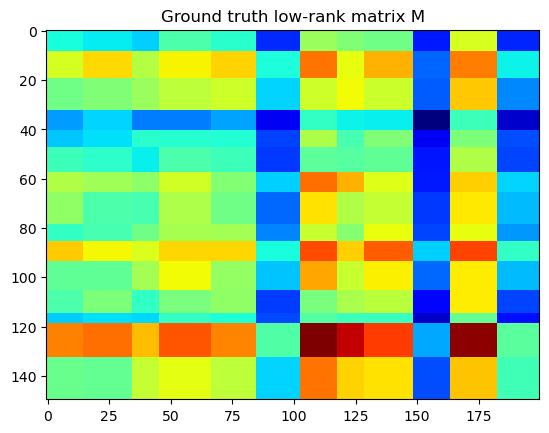

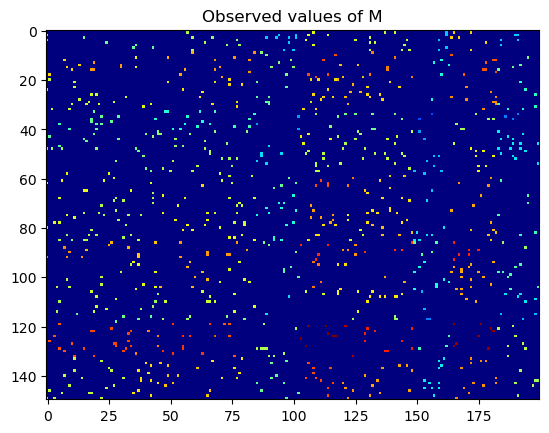

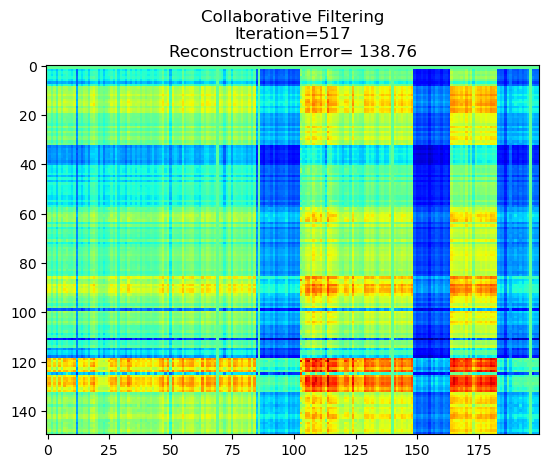

In [23]:
# Collaborative filtering / low-rank approximation by nuclear norm

# Norm of the operator
OM = O*M
normOM = np.linalg.norm(OM,2)

#######################################
# Select the set of hyper-parameters
#######################################

# scenario : very low number of ratings, 0.03%, error metric = 138.75
lambdaNuc = normOM/4; lambdaDF = 1e1

# Indentify zero columns and zero rows in the data matrix X
idx_zero_cols = np.where(np.sum(Otraining,axis=0)<1e-9)[0]
idx_zero_rows = np.where(np.sum(Otraining,axis=1)<1e-9)[0]
nb_zero_cols = len(idx_zero_cols)
nb_zero_rows = len(idx_zero_rows)
   
# Initialization
X = M; Xb = X;
Y = np.zeros([n,m])
normA = 1.
sigma = 1./normA
tau = 1./normA
diffX = 1e10
min_nm = np.min([n,m])
k = 0
while (k<2000) & (diffX>1e-1):
    
    # Update iteration
    k += 1
        
    ############################################################################
    # Your code start
    # Update the dual variable Y
    ############################################################################
    Y = Y + sigma * Xb # Why do we need to update Y
    U, S, V = np.linalg.svd(Y / sigma)
    # shrink operator returns a 1D array of size n
    shrinked = shrink(S, lambdaNuc/sigma)
    # Since shrink requires a size of n, m for matrix calculations, we will convert it from size n to n, m
    shrinked_nm = np.zeros((n, m))
    I = np.array(range(min_nm))
    shrinked_nm[I, I] = shrinked
    Y = Y - sigma * U.dot(shrinked_nm.dot(V)) 
    ############################################################################
    # Your code end
    ############################################################################
    
    ############################################################################
    # Your code start
    # Update the primal variable X
    ############################################################################
    Xold = X
    X = (X - tau * Y + tau * lambdaDF * M) / (1 + tau * lambdaDF * O)
    ############################################################################
    # Your code end
    ############################################################################
    
    # Fix issue with no observations along some rows and columns
    r,c = np.where(X>0.0); median = np.median(X[r,c])
    if nb_zero_cols>0: X[:,idx_zero_cols] = median
    if nb_zero_rows>0: X[nb_zero_rows,:] = median

    # Update primal variable xb
    Xb = 2.* X - Xold
        
    # Difference between two iterations
    diffX = np.linalg.norm(X-Xold) 
    
    # Reconstruction error
    err_test = np.sqrt(np.sum((Otest*(X-Mgt))**2)) / np.sum(Otest) * (n*m)

    # Plot
    if not k%50:
        clear_output(wait=True)
        plt.figure(1)
        plt.imshow(X, interpolation='nearest', cmap='jet')
        plt.title('Collaborative Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,5)))
        plt.show()        
        print('diffX',diffX)


clear_output(wait=True) 
print('Reconstruction Error: '+ str(round(err_test,5)))

# Final plot
plt.figure(2)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Ground truth low-rank matrix M')

plt.figure(3)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M')

plt.figure(4)
plt.imshow(X, interpolation='nearest', cmap='jet')
plt.title('Collaborative Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,2)))
plt.show()



# Real-world dataset SWEETRS

### Question 2 : Explore different sparsity scenarios for real-world ratings

Try out the following sparsity scenarios:
* Scenario 1 : 1.3% known ratings
* Scenario 2 : 13.1% known ratings
* Scenario 3 : 52.7% known ratings

Given that the reconstruction term weight is set to `lambdaDF = 1e1`, should the weight of the low-rank term `lambdaNuc` be increased or decreased as the number of available ratings decreases?


In [24]:
# Load graphs of rows/users and columns/products
mat = scipy.io.loadmat('datasets/real_sweetrs_scenario1.mat') # 1.3%
mat = scipy.io.loadmat('datasets/real_sweetrs_scenario2.mat') # 13.1%
# mat = scipy.io.loadmat('datasets/real_sweetrs_scenario3.mat') # 52.7%
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
print('M', M.shape)
print('Otraining', Otraining.shape)
print('Otest', Otest.shape)
print('Wrow', Wrow.shape)
print('Wcol', Wcol.shape)

n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining) / (n*m)
print('perc_obs_training=',perc_obs_training)
perc_obs_test = np.sum(Otest) / (n*m)


M (664, 77)
Otraining (664, 77)
Otest (664, 77)
Wrow (664, 664)
Wcol (77, 77)
n,m= 664 77
perc_obs_training= 0.1317868878109842


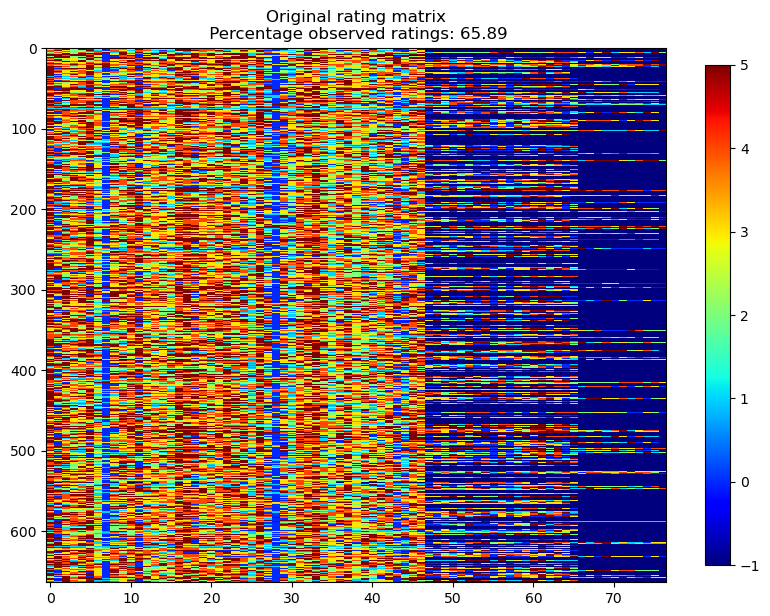

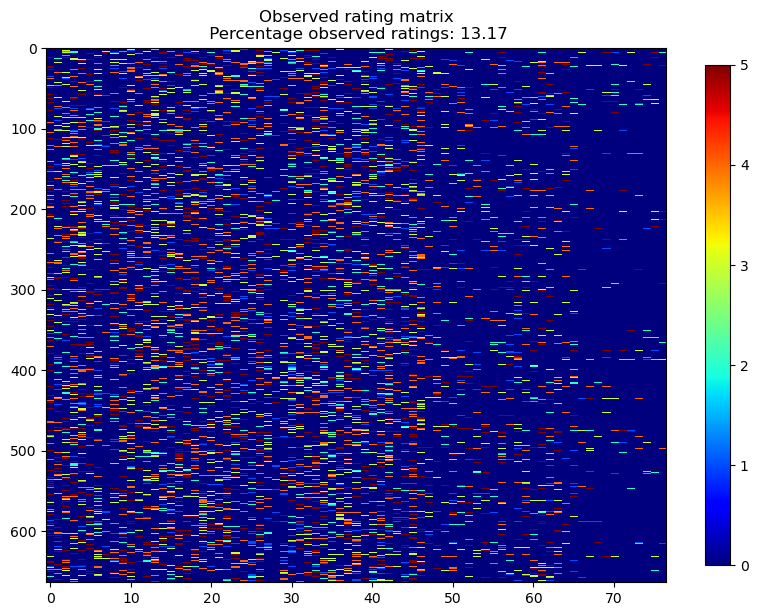

In [25]:
# Visualize the original rating matrix
plt.figure(1,figsize=(10,10))
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*np.sum(Mgt>0)/(n*m))[:5])

# Visualize the observed rating matrix
plt.figure(2, figsize=(10,10))
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Observed rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_training)[:5])
plt.show()


In [26]:
# Collaborative filtering / low-rank approximation by nuclear norm

# Norm of the operator
OM = O*M
normOM = np.linalg.norm(OM,2)

#######################################
# Select the set of hyper-parameters
#######################################

# scenario 1 : low number of ratings, 1.3%, error metric = 743.6  
lambdaNuc = normOM/4 * 5 ; lambdaDF = 1e1

# # scenario 2 : intermediate number of ratings, 13.1%, error metric = 405.9 
lambdaNuc = normOM/4 * 2.5; lambdaDF = 1e1

# # scenario 3 : large number of ratings, 52.7%, error metric = 699.3
# lambdaNuc = normOM/4 * 1; lambdaDF = 1e1


# Indentify zero columns and zero rows in the data matrix X
idx_zero_cols = np.where(np.sum(Otraining,axis=0)<1e-9)[0]
idx_zero_rows = np.where(np.sum(Otraining,axis=1)<1e-9)[0]
nb_zero_cols = len(idx_zero_cols)
nb_zero_rows = len(idx_zero_rows)
   
# Initialization
X = M; Xb = X;
Y = np.zeros([n,m])
normA = 1.
sigma = 1./normA
tau = 1./normA
diffX = 1e10
min_nm = np.min([n,m])
k = 0
while (k<2000) & ( diffX>1e-1 or k<100 ) :
    
    # Update iteration
    k += 1
        
    # Update dual variable y
    Y = Y + sigma* Xb
    U,S,V = np.linalg.svd(Y/sigma)
    Sdiag = shrink( S , lambdaNuc/ sigma )
    I = np.array(range(min_nm))
    Sshrink = np.zeros([n,m])
    Sshrink[I,I] = Sdiag
    Y = Y - sigma* U.dot(Sshrink.dot(V))    
    
    # Update primal variable x
    Xold = X
    X = X - tau* Y
    X = ( X + tau* lambdaDF* O* M)/ (1 + tau* lambdaDF* O)
    # Fix issue with no observations along some rows and columns
    r,c = np.where(X>0.0); median = np.median(X[r,c])
    if nb_zero_cols>0: X[:,idx_zero_cols] = median
    if nb_zero_rows>0: X[nb_zero_rows,:] = median

    # Update primal variable xb
    Xb = 2.* X - Xold
        
    # Difference between two iterations
    diffX = np.linalg.norm(X-Xold)
        
    # Reconstruction error
    err_test = np.sqrt(np.sum((Otest*(X-Mgt))**2)) / np.sum(Otest) * (n*m)
    
    # Plot
    if not k%50:
        clear_output(wait=True)   
        plt.figure(figsize=(10,10))
        plt.imshow(X, interpolation='nearest', cmap='jet', aspect=0.1)
        plt.colorbar(shrink=0.65)
        plt.title('Collaborative Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,5)))
        plt.show()
        print('diffX',diffX)

clear_output(wait=True) 
print('Reconstruction Error: '+ str(round(err_test,5)))
  

# Final plots
plt.figure(2, figsize=(10,10))
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*np.sum(Mgt>0)/(n*m))[:5])
plt.show()

plt.figure(3, figsize=(10,10))
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Observed rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_training)[:5])
plt.show()

plt.figure(4, figsize=(10,10))
plt.imshow(X, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Collaborative Filtering\nIteration='+ str(k)+'\nReconstruction Error= '+ str(round(err_test,5)))
plt.show()



NameError: name 'XXX' is not defined